In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias.html

In [2]:
filename = 'covid19-es-and.csv'
fecha = '22/10/2020'
id_noticia = '245194'
url = 'https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias/detalle/' + id_noticia + '.html'

In [3]:
def DrawMediaFlotante (dfData, provincia, dias):   
    data = dfData.loc[provincia].diff().tail(dias).copy()
    data['Media Positivo 7 dias'] = data['PCR Positivo'].rolling(window=7).mean()
    data['Media Positivo 14 dias'] = data['PCR Positivo'].rolling(window=14).mean()
    titulo = 'Nuevos casos en los últimos ' + str(dias) + ' días en ' + provincia
    # print(titulo + '. (Nuevos positivos e ingresos hospitalarios)')
    data[['Hospitalización', 'PCR Positivo', 'Media Positivo 7 dias', 'Media Positivo 14 dias']].plot(
        kind='line', grid=True, figsize=(15,5), title=titulo)
    plt.xticks(
        rotation=45,    
        horizontalalignment='right',
        fontweight='light',
    )
    plt.show()
    

In [4]:
# FIX SSL: CERTIFICATE_VERIFY_FAILED with Python3
# https://stackoverflow.com/a/49174340
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# Load
tables = pd.read_html(url, header=0, thousands='.')
assert len(tables) > 0
dfL = tables[0]

In [6]:
# Prepare
dfL.columns = ['Provincia', 'PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']
dfL['Fecha'] = fecha
# A partir del 14/05/2020 se cambia el formato del dato añadiendo en la misma columna el número de nuevos casos
for col in ['PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']:
    dfL[col] = dfL[col].str.split(' ').str[0].str.replace('*', '')

dfL

,Provincia,PCR Positivo,Hospitalización,UCI,Fallecimientos,Curados,Fecha
0,Almería,9.819,814,107,136,7.575,22/10/2020
1,Cádiz,10.173,1.139,127,260,4.555,22/10/2020
2,Córdoba,11.145,1.220,146,226,4.229,22/10/2020
3,Granada,17.045,1.887,168,401,4.802,22/10/2020
4,Huelva,2.758,343,36,66,874,22/10/2020
5,Jaén,9.375,1.286,130,260,3.771,22/10/2020
6,Málaga,20.202,2.643,249,463,11.867,22/10/2020
7,Sevilla,23.672,2.709,238,474,6.999,22/10/2020
8,Total,104.189,12.041,1.201,2.286,44.672,22/10/2020


In [7]:
data = pd.melt(dfL, id_vars=['Provincia', 'Fecha'])
# data.sample(5)

In [8]:
# Save to csv
data.to_csv(filename, encoding='utf-8', header=False, mode='+a', index=False)

In [9]:
# Load full csv
dfL = pd.read_csv(filename, thousands='.', parse_dates=['Fecha'], dayfirst=True)
# dfL.tail()

In [10]:
# Guardar el último día
last_fecha = dfL['Fecha'].max()

In [11]:
# Organizar en forma de tabla
df = pd.pivot_table(dfL, values='value', index=['Provincia', 'Fecha'], columns='variable')
df.sort_index(inplace=True)

In [12]:
# Variaciones con respecto al día anterior
dfV = df.groupby(level='Provincia').diff()
# dfV.tail()

In [13]:
# Para seleccionar todas las filas de una o varias fechas hay que usar un trick ya que : no se puede usar en este caso
dfG = dfV.loc[(slice(None), [last_fecha]), :]
dfG

,variable,Curados,Fallecimientos,Hospitalización,PCR Positivo,UCI
Provincia,Fecha,,,,,
Almería,2020-10-22,226.0,4.0,6.0,162.0,0.0
Cádiz,2020-10-22,91.0,1.0,18.0,203.0,1.0
Córdoba,2020-10-22,104.0,5.0,21.0,255.0,4.0
Granada,2020-10-22,82.0,11.0,28.0,786.0,1.0
Huelva,2020-10-22,21.0,0.0,10.0,178.0,0.0
Jaén,2020-10-22,52.0,5.0,27.0,265.0,5.0
Málaga,2020-10-22,406.0,6.0,33.0,306.0,2.0
Sevilla,2020-10-22,48.0,12.0,28.0,799.0,5.0
Total,2020-10-22,1030.0,44.0,171.0,2954.0,18.0


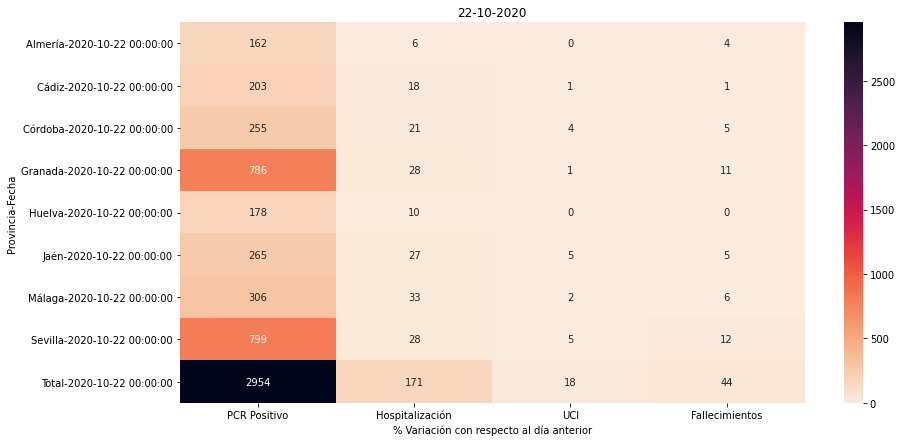

In [14]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title(last_fecha.strftime('%d-%m-%Y'))

# Invertir los colores
cmap = sns.cm.rocket_r

# Heatmap 
sns.heatmap(data=dfG[['PCR Positivo', 'Hospitalización', 'UCI', 'Fallecimientos']], annot=True, cmap=cmap,fmt='g')

# Add label for horizontal axis
plt.xlabel('% Variación con respecto al día anterior')
plt.show()

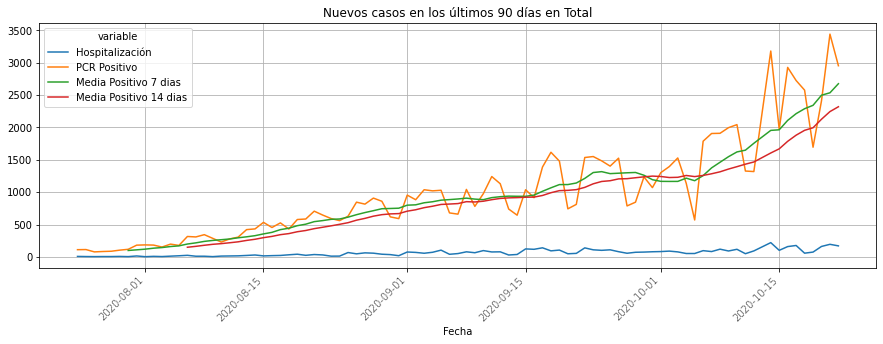

In [15]:
DrawMediaFlotante(df, 'Total', 90)

In [16]:
# Fecha de último ingreso en hospital
data = df[['Hospitalización']].diff()
data = data[data['Hospitalización'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values('dias', ascending=False)

variable,Fecha,Hospitalización,dias
Provincia,,,
Total,2020-10-22,171.0,0 days
Sevilla,2020-10-22,28.0,0 days
Málaga,2020-10-22,33.0,0 days
Jaén,2020-10-22,27.0,0 days
Huelva,2020-10-22,10.0,0 days
Granada,2020-10-22,28.0,0 days
Córdoba,2020-10-22,21.0,0 days
Cádiz,2020-10-22,18.0,0 days
Almería,2020-10-22,6.0,0 days


In [17]:
# Fecha de último ingreso en hospital
data = df[['UCI']].diff()
data = data[data['UCI'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values('dias', ascending=False)

variable,Fecha,UCI,dias
Provincia,,,
Huelva,2020-10-02,1.0,20 days
Almería,2020-10-10,1.0,12 days
Total,2020-10-22,18.0,0 days
Sevilla,2020-10-22,5.0,0 days
Málaga,2020-10-22,2.0,0 days
Jaén,2020-10-22,5.0,0 days
Granada,2020-10-22,1.0,0 days
Córdoba,2020-10-22,4.0,0 days
Cádiz,2020-10-22,1.0,0 days


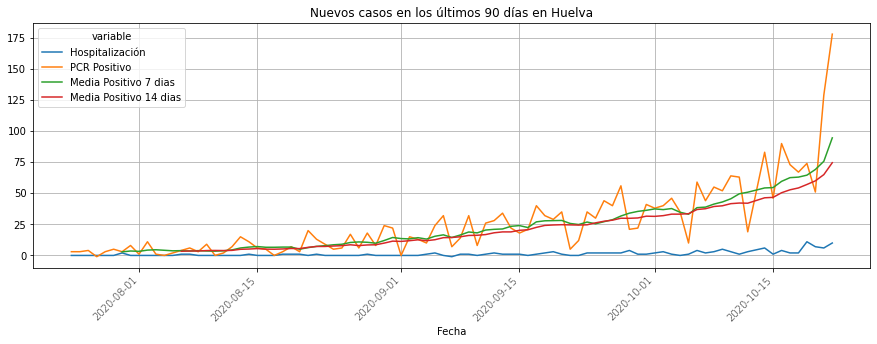

In [18]:
DrawMediaFlotante(df, 'Huelva', 90)